# Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [35]:
import sys
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
import tensorflow as tf
import tensorflow_datasets as tfds
warnings.filterwarnings("ignore")

# tensorflow keras API

케라스는 고수준 신경망 API다.

케라스는 사용자에게 편리하고 모듈식 프로그래밍 인터페이스르 제공하기에 몇 줄의 코드로 복잡한 모델을 빠르게 만들 수 있다.

케라스는 텐서플로와 밀접하게 통합되어 있어 별도의 설치 없이 tf.keras에서 바로 사용할 수 있다. 

텐서플로 2.0에서 tf.keras가 텐서플로의 대표 API가 되었으며 모델을 만드는 데 권장되는 방법이다.

# 선형 회귀 모델 만들기

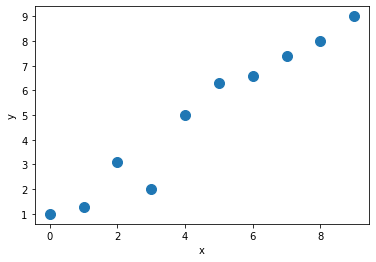

In [6]:
X_train=np.arange(10).reshape((10,1))
y_train=np.array([1,1.3,3.1,2,5,6.3,6.6,7.4,8,9])

plt.plot(X_train,y_train,'o',markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
X_train_norm=(X_train-np.mean(X_train))/np.std(X_train)
ds_train_orig=tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm,tf.float32),
     tf.cast(y_train,tf.float32)))

In [14]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b

In [15]:
model = MyModel()
model.build(input_shape=(None,1))
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


model.build에서 입력 텐서의 첫 번째 차원을 None으로 하였는데 이러면 임의의 배치 크기를 사용하였다.

하지만 특성 개수는 모델의 가중치 파라미터 개수와 직접적으로 관련되기 때문에 고정적이다. 

객체를 만든 후 build 매서드를 호출해 모델 층과 파라미터를 만드는 방법을 변수 지연 생성이라고 한다.

모델을 정의한 후 최적의 모델 가중치를 찾기 위해 최소화할 비용 함수 정의

평균 제곱 오차 사용

확률적 경사 하강법 사용

In [20]:
def loss_fn(y_true,y_pred):
  return tf.reduce_mean(tf.square(y_true-y_pred))

def train(model,inputs,outputs,learning_rate):
  with tf.GradientTape() as tape:
    current_loss=loss_fn(model(inputs),outputs)
  dW, db=tape.gradient(current_loss,[model.w,model.b])
  model.w.assign_sub(learning_rate*dW)
  model.b.assign_sub(learning_rate*db)

In [28]:
tf.random.set_seed(1)
num_epochs=200
log_steps=100
learning_rate=0.001
batch_size=1
steps_per_epoch=int(np.ceil(len(y_train)/batch_size))
ds_train=ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train=ds_train.repeat(count=None)
ds_train=ds_train.batch(1)
Ws,bs=[],[]

for i,batch in enumerate(ds_train):
  if i>=steps_per_epoch*num_epochs:
    break
  Ws.append(model.w.numpy())
  bs.append(model.b.numpy())

  bx,by=batch
  loss_val=loss_fn(model(bx),by)

  train(model,bx,by,learning_rate=learning_rate)
  if i%log_steps==0:
    print('에포크 {:3d} 스텝 {:4d} 손실 {:6.4f}'.format(
        int(i/steps_per_epoch),i,loss_val))

에포크   0 스텝    0 손실 8.7616
에포크  10 스텝  100 손실 0.2791
에포크  20 스텝  200 손실 4.2186
에포크  30 스텝  300 손실 3.8354
에포크  40 스텝  400 손실 1.8738
에포크  50 스텝  500 손실 1.4673
에포크  60 스텝  600 손실 0.1338
에포크  70 스텝  700 손실 0.1216
에포크  80 스텝  800 손실 1.7678
에포크  90 스텝  900 손실 1.7016
에포크 100 스텝 1000 손실 0.4066
에포크 110 스텝 1100 손실 0.0852
에포크 120 스텝 1200 손실 0.1283
에포크 130 스텝 1300 손실 0.0000
에포크 140 스텝 1400 손실 0.0008
에포크 150 스텝 1500 손실 0.0820
에포크 160 스텝 1600 손실 0.3358
에포크 170 스텝 1700 손실 2.2676
에포크 180 스텝 1800 손실 0.0296
에포크 190 스텝 1900 손실 0.2960


훈련한 모델을 확인하고 그래프로 그리기

In [29]:
print('최종 파라미터:',model.w.numpy(),model.b.numpy())

최종 파라미터: 2.6856232 4.931349


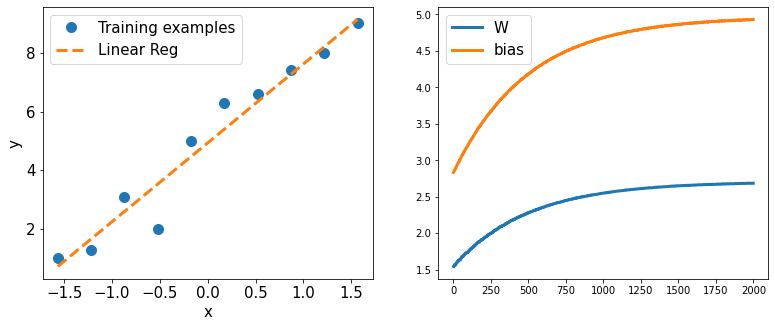

In [30]:
X_test=np.linspace(0,9,num=100).reshape(-1,1)
X_test_norm=(X_test-np.mean(X_train))/np.std(X_train)
y_pred=model(tf.cast(X_test_norm,dtype=tf.float32))

fig=plt.figure(figsize=(13,5))

ax=fig.add_subplot(1,2,1)
plt.plot(X_train_norm,y_train,'o',markersize=10)
plt.plot(X_test_norm,y_pred,'--',lw=3)

plt.legend(['Training examples','Linear Reg'],fontsize=15)
ax.set_xlabel('x',size=15)
ax.set_ylabel('y',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()

complie과 fit을 이용한 모델 훈련

In [31]:
tf.random.set_seed(1)
model=MyModel()
model.compile(optimizer='sgd',
              loss=loss_fn,
              metrics=['mae','mse'])

In [32]:
model.fit(X_train_norm,y_train,epochs=num_epochs,batch_size=batch_size,verbose=1)

Epoch 1/200
10/10 [==============================] - 0s 2ms/step - loss: 27.8723 - mae: 4.5654 - mse: 27.8723
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 18.6586 - mae: 3.7446 - mse: 18.6586
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 12.5239 - mae: 3.0454 - mse: 12.5239
Epoch 4/200
10/10 [==============================] - 0s 2ms/step - loss: 8.4670 - mae: 2.4907 - mse: 8.4670
Epoch 5/200
10/10 [==============================] - 0s 2ms/step - loss: 5.7632 - mae: 2.0567 - mse: 5.7632
Epoch 6/200
10/10 [==============================] - 0s 2ms/step - loss: 3.9697 - mae: 1.7232 - mse: 3.9697
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 2.7766 - mae: 1.4752 - mse: 2.7766
Epoch 8/200
10/10 [==============================] - 0s 2ms/step - loss: 1.9861 - mae: 1.2578 - mse: 1.9861
Epoch 9/200
10/10 [==============================] - 0s 2ms/step - loss: 1.4572 - mae: 1.0978 - mse: 1.4572
Epoch 10/200
10/10 [==

붓꽃 데이터셋을 분류하는 다층 퍼셉트론 만들기

In [36]:
iris,iris_info=tfds.load('iris',with_info=True)
print(iris_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/iris/2.0.0.incompleteQD3YDH/iris-train.tfrecord


  0%|          | 0/150 [00:00<?, ? examples/s]

Dataset iris downloaded and prepared to /root/tensorflow_datasets/iris/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='iris',
    version=2.0.0,
    description='This is perhaps the best known database to be found in the pattern recognition
literature. Fisher's paper is a classic in the field and is referenced
frequently to this day. (See Duda & Hart, for example.) The data set contains
3 classes of 50 instances each, where each class refers to a type of iris
plant. One class is linearly separable from the other 2; the latter are NOT
linearly separable from each other.',
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=150,
    splits={
        'train': 150,
    },
    supervised_keys=('features', 'label'),
    citation="""@misc{Dua:2019 ,
    author = "Dua, D

훈련 샘플과 테스트 샘플 나누기

데이터셋이 섞여 있지 않다면 데이터셋을 섞을 수도 있는데 훈련 샘플과 테스트 샘플을 섞이는 경우도 발생할 수 있다.

이 경우는 머신러닝에서 용납되지 않는다.

이를 피하려면 reshuffle each iteration을 False로 지정

In [39]:
tf.random.set_seed(1)
ds_orig=iris['train']
ds_orig=ds_orig.shuffle(150,reshuffle_each_iteration=False)
ds_train_orig=ds_orig.take(100)
ds_test=ds_orig.skip(100)

In [41]:
#딕셔너리를 튜플로 변환

ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

tf.keras.Sequential 클래스를 사용하면 몇 개의 케라스 층을 쌓아 신경망을 만들 수 있는데

여기서는 완전 연결 층, 선형 층인 Dense 층을 사용한다.

각 층은 이전 층으로부터 입력을 받으므로 차원이 고정된다.

In [43]:
iris_model=tf.keras.Sequential([
                                tf.keras.layers.Dense(16,activation='sigmoid',name='fc1',input_shape=(4,)),
                                tf.keras.layers.Dense(3,name='fc2',activation='softmax')
])

iris_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [44]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [45]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

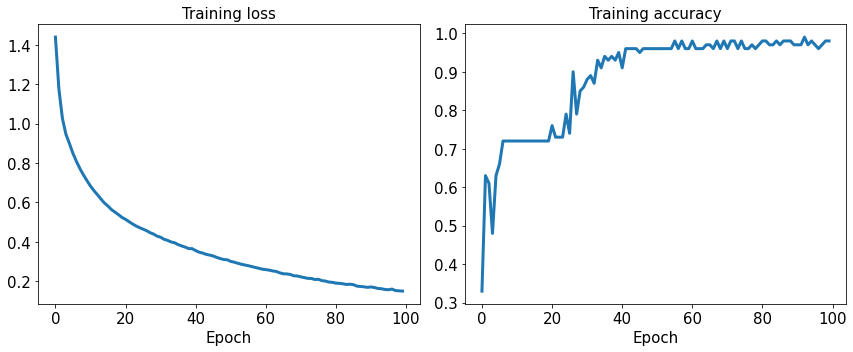

In [46]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
# plt.savefig('images/13_7.png', dpi=300)
plt.show()

테스트 데이터셋에서 훈련된 모델 평가

In [47]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('테스트 손실: {:.4f}   테스트 정확도: {:.4f}'.format(*results))

테스트 손실: 0.1483   테스트 정확도: 0.9800


훈련된 모델 저장하고 복원

In [49]:
iris_model.save('iris-classifier.h5',
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

In [51]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [52]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('테스트 손실: {:.4f}   테스트 정확도: {:.4f}'.format(*results))

테스트 손실: 0.1483   테스트 정확도: 0.9800


케라스 모델의 fit 메서드는 callback 매개변수를 활용해 훈련과정을 제어할 수 있다.

예를 들어 모델을 훈련하는 동안 ModelCheckpoint 콜백을 사용하여 최고의 성능을 내는 가중치를 저장할 수 있다.

ModelCheckpoint 콜백은 더 이상 성능이 개선되지 않을 때 훈련을 멈추게 하는 EarlyStopping 콜백과 함께 사용하는 경우 많다.

조기 종료 콜백 클래스는 기본적으로 검증 손실을 모니터링한다.

patience 매개변수가 지정한 에포크 횟수 동안 모니터링 지표가 개선되지 않으면 훈련을 중지한다.

In [53]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callback_list=[ModelCheckpoint(filepath='iris-earlystopping.h5',
                               monitor='val_loss'),
               EarlyStopping(patience=3,restore_best_weights=True)]

그 다음 Sequential 클래스를 사용하지 않고 iris_model 모델의 구조를 추출하여 새로운 모델을 만들어 보겠다.

model_from_json() 함수를 사용하여 to_json() 메서드로 만든 구조로 새로운 모델을 만들 수 있다.

compile() 메서드에 지정한 것은 이전과 동일합니다.

fit() 메서드에는 validation_data 매개변수에 검증 데이터셋으로 사용할 데이터를 전달한다.

callbacks 매개변수에 앞에서 만든 콜백 리스트를 전달한다.

에포크를 크게 설정해도(epochs=500) 조기 종료를 사용하기 때문에 종료 조건이 만족되면 훈련이 중간에 중단될 것이다.

In [54]:
tf.random.set_seed(1)

model = tf.keras.models.model_from_json(iris_model.to_json())
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train, epochs=500, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=ds_test.batch(50), 
                    callbacks=callback_list,
                    verbose=0)

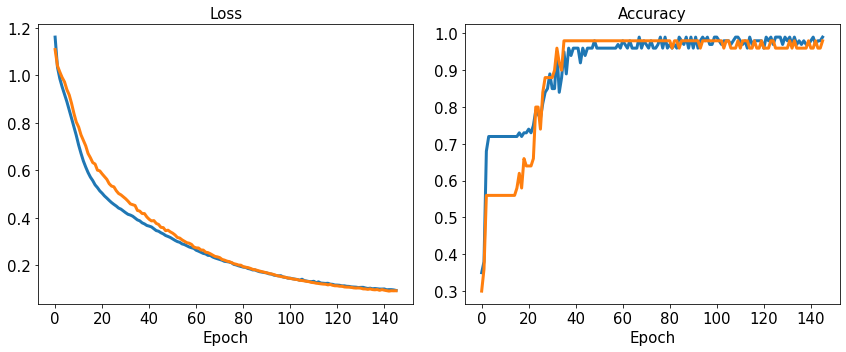

In [55]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.plot(hist['val_loss'], lw=3)
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.plot(hist['val_accuracy'], lw=3)
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
# plt.savefig('images/13_earlystopping.png', dpi=300)
plt.show()

In [56]:
callback_list[1].stopped_epoch

145

텐서 보드

모델의 학습 과정뿐만 아니라 계산 그래프도 시각화 가능

In [57]:
from tensorflow.keras.callbacks import TensorBoard

callback_list = [ModelCheckpoint(filepath='iris-earlystopping.h5', 
                                 monitor='val_loss'),
                 EarlyStopping(patience=3, restore_best_weights=True),
                 TensorBoard()]

In [58]:
tf.random.set_seed(1)

model = tf.keras.models.model_from_json(iris_model.to_json())
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train, epochs=500, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=ds_test.batch(50), 
                    callbacks=callback_list,
                    verbose=0)